## **Random Forest Model Implementation for real world data**


**Defining the node class**

In [ ]:

import numpy as np
from collections import Counter

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):
        self.left = left
        self.right = right
        self.value = value
        self.threshold = threshold
        self.feature = feature
        
    def check_node_leaf(self):
        return self.value is not None


**Defining the Decision Tree Model Class**

In [ ]:
class DecisionTree:
    # class initialization
    def __init__(self, minimum_samples_for_split=2, depth_maximum=100, number_of_features=None):
        self.minimum_samples_for_split=minimum_samples_for_split
        self.depth_maximum=depth_maximum
        self.number_of_features=number_of_features
        self.root=None

    # model fit method
    def fitting(self, X, y):
        self.number_of_features = X.shape[1] if not self.number_of_features else min(X.shape[1],self.number_of_features)
        self.root = self.build_decision_tree(X, y)

    # building of the decision tree
    def build_decision_tree(self, X, y, depth=0):
        number_of_samples, num_of_feats_procured = X.shape
        number_of_labels = len(np.unique(y))

        # check the stopping criteria
        if (number_of_labels == 1 or  number_of_samples < self.minimum_samples_for_split or depth >= self.depth_maximum):
            leaf_value = self.prominent_feature(y)
            tempRes = Node(value=leaf_value)
            return tempRes

        feature_indexes = np.random.choice(num_of_feats_procured, self.number_of_features, replace=False)

        # find the best split
        feat_best, thresh_best = self.calculate_split_best(X, y, feature_indexes)

        # create child nodes
        indexes_left_side, indexes_right_side = self.find_split(X[:, feat_best], thresh_best)
        subtree_right = self.build_decision_tree(X[indexes_right_side, :], y[indexes_right_side], depth+1)
        subtree_left = self.build_decision_tree(X[indexes_left_side, :], y[indexes_left_side], depth+1)

        return Node(feat_best, thresh_best, subtree_left, subtree_right)

    # model prediction code
    def prediction_calculation(self, X):
        return np.array([self.tree_traversal(x, self.root) for x in X])

    def tree_traversal(self, x, node):
        if node.check_node_leaf():
            return node.value

        if node.threshold >= x[node.feature]:
            return self.tree_traversal(x, node.left)

        return self.tree_traversal(x, node.right)
    
    # below is the list of all the helper functions

    def calculate_split_best(self, X, y, feature_indexes):
        gain_initial = -1
        index_threshold, threshold_split = None, None

        for feat_idx in feature_indexes:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                # calculate the information gain for deciding the best-split
                gain = self.info_gain(y, X_column, thr)

                if gain > gain_initial:
                    gain_initial = gain
                    index_threshold = feat_idx
                    threshold_split = thr

        return index_threshold, threshold_split


    def info_gain(self, y, X_column, threshold):
        parent_entropy = self.compute_entropy(y)

        # create children
        indexes_left_side, indexes_right_side = self.find_split(X_column, threshold)

        if len(indexes_left_side) == 0 or len(indexes_right_side) == 0:
            return 0
        
        # calculate the weighted avg. entropy of children
        total_number = len(y)

        # getting the length/count of left and right indexes
        length_right = len(indexes_right_side)
        length_left = len(indexes_left_side)

        # num of left and right idxs entropies
        entropy_left, right_entropy = self.compute_entropy(y[indexes_left_side]), self.compute_entropy(y[indexes_right_side])
        
        child_entropy = (length_left/total_number) * entropy_left + (length_right/total_number) * right_entropy

        # calculate the IG
        information_gain = parent_entropy - child_entropy
        return information_gain

    # changed methods below
    def find_split(self, X_column, split_thresh):
        # here the right and left indices split is decided
        indexes_right_side = np.argwhere(split_thresh < X_column).flatten()
        indexes_left_side = np.argwhere(split_thresh >= X_column).flatten()
        
        return indexes_left_side, indexes_right_side

    def compute_entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        
        # entropy formula
        return -np.sum([p * np.log(p) for p in ps if p>0])


    # utilizing the counter library for calculating the prominent feature
    def prominent_feature(self, y):
        ctr = Counter(y)
        val = ctr.most_common(1)[0][0]
        return val
    # changed methods above


**Defining the RandomForest class**

In [ ]:
# from DecisionTrees import DecisionTree
import numpy as np
from collections import Counter

class RandomForest:
    # initializing the random forest
    def __init__(self, number_of_trees=10, depth_maximum=10, minimum_samples_for_split=2, n_feature=None):
        self.depth_maximum=depth_maximum
        self.minimum_samples_for_split=minimum_samples_for_split
        self.number_of_features=n_feature
        self.number_of_trees = number_of_trees
        self.trees = []

    # model fit
    def fitting(self, X, y):
        self.trees = []
        for _ in range(self.number_of_trees):
            tree_result = DecisionTree(depth_maximum=self.depth_maximum,minimum_samples_for_split=self.minimum_samples_for_split,number_of_features=self.number_of_features)
            samples_X, samples_Y = self.sampling_bootstrap(X, y)
            tree_result.fitting(samples_X, samples_Y)
            self.trees.append(tree_result)

    # performing bootstrap smpling
    def sampling_bootstrap(self, X, y):
        n_samples = 12
        # POINT FOR RANDOMEESS  IN DATA
        idxs = np.random.choice(X.shape[0], n_samples, replace=True)
        return X[idxs], y[idxs]

    # calculating the prominent feature
    def prominent_feature(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

    # calculating the prediction
    def prediction_calculation(self, X):
        predictions_results = np.array([tree.prediction_calculation(X) for tree in self.trees])
        prediction_of_trees = np.swapaxes(predictions_results, 0, 1)
        predictions_results = np.array([self.prominent_feature(pred) for pred in prediction_of_trees])
        return predictions_results

## The below code is for testing the above implementations

**Adding the necessary imports**

In [ ]:
from random import random
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score

**Preparing the data**

In [ ]:
data = datasets.load_breast_cancer()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=2359
)


**Defining accuracy**

In [ ]:

def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy


**Executing the Random forest model for various scenarios**

In [ ]:
random_forest = RandomForest(number_of_trees=20)   #accuracy --> 93.71
# random_forest = RandomForest(number_of_trees=5)  #accuracy --> 86.71
# random_forest = RandomForest(number_of_trees=40) #accuracy --> 92.30
# random_forest = RandomForest(number_of_trees=50) #accuracy --> 91.6

random_forest.fitting(X_train, y_train)
predictions = random_forest.prediction_calculation(X_test)
acc =  accuracy(y_test, predictions)
print('acc', acc)


acc 0.9370629370629371


**Calculating the correctness scores of the random forest-**

In [ ]:

f1 = f1_score(y_test, predictions, average='weighted')
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')

# Print the F1 score, precision, and recall
print("F1 score: {:.2f}".format(f1)) #0.91
print("Precision: {:.2f}".format(precision)) #0.92
print("Recall: {:.2f}".format(recall)) #0.91


F1 score: 0.94
Precision: 0.94
Recall: 0.94


**Compute confusion matrix**

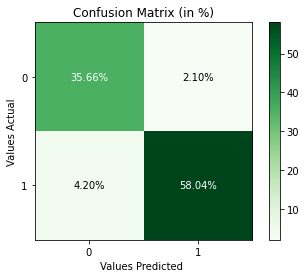

In [ ]:

conf_matrix = confusion_matrix(y_test, predictions)

# Calculate the sum of all values in confusion matrix
conf_matrix_sum = np.sum(conf_matrix)

# Compute percentages for each value in confusion matrix
conf_matrix_percent = conf_matrix / conf_matrix_sum * 100

# Define the class names
class_names = ['0', '1']

# Plot the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(conf_matrix_percent, cmap='Greens')

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set tick labels
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)

# Loop over data dimensions and create text annotations
thresh = conf_matrix_percent.max() / 2.
for i in range(len(class_names)):
    for j in range(len(class_names)):
        ax.text(j, i, "{:.2f}%".format(conf_matrix_percent[i, j]), ha="center", va="center", color="white" if conf_matrix_percent[i, j] > thresh else "black")

# Set title and axis labels
ax.set_title("Confusion Matrix (in %)")
ax.set_xlabel("Values Predicted ")
ax.set_ylabel("Values Actual")

# Show plot
plt.show()

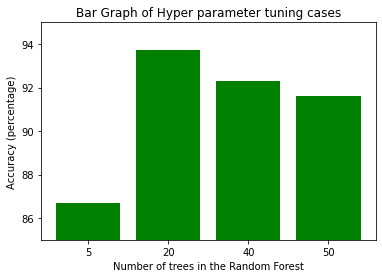

In [ ]:
#plotting bar graph of accuracies done with various number of trees -
values = [86.71, 93.71, 92.3, 91.6]

# Create x-axis values
x_pos = [i for i in range(len(values))]

# Plot the bar graph
plt.ylim(85,95)
plt.bar(x_pos, values, color='green')

# Add x-axis labels
plt.xticks(x_pos, ['5', '20', '40', '50'])

# Add y-axis label
plt.ylabel('Accuracy (percentage)')
plt.xlabel('Number of trees in the Random Forest')

# Add title
plt.title('Bar Graph of Hyper parameter tuning cases')

# Show the plot
plt.show()